In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torch.nn.modules.distance import PairwiseDistance
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
model = models.resnet50(pretrained='vggface2').cuda()
model.fc = nn.Linear(in_features=2048,out_features=128).cuda()
model=model.cuda()

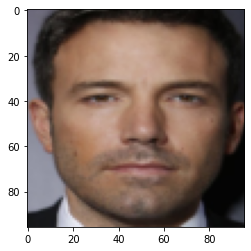

Ben


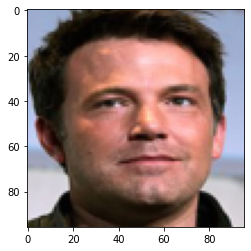

Ben


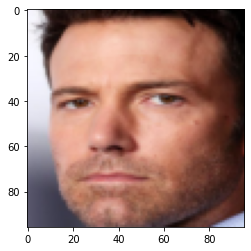

Ben


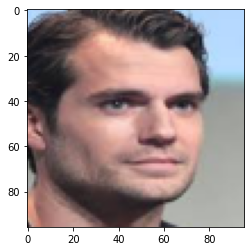

Henry


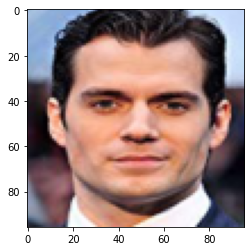

Henry


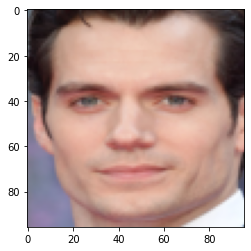

Henry


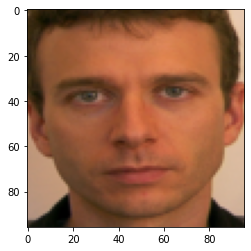

A


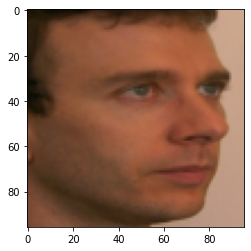

A


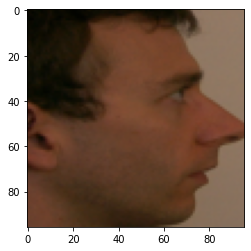

A


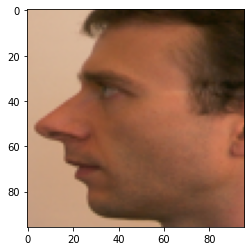

A


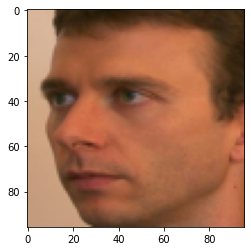

A


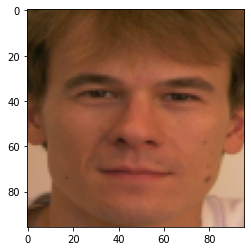

B


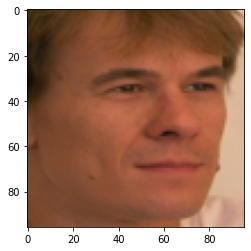

B


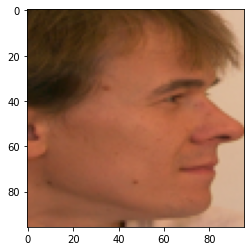

B


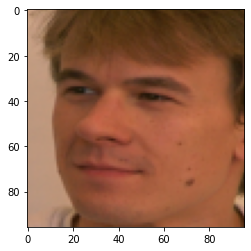

B


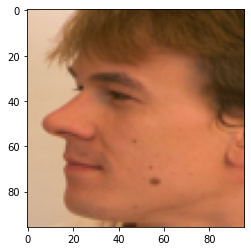

B


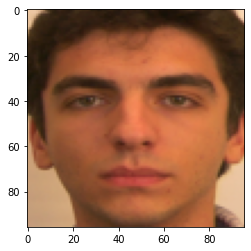

D


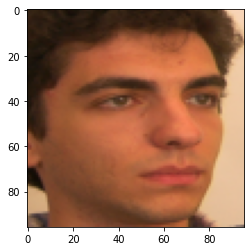

D


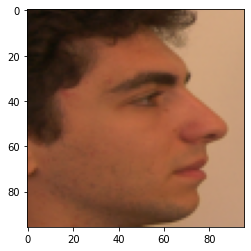

D


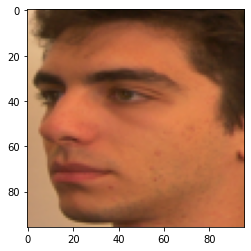

D


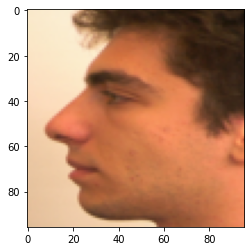

D


In [ ]:
paths = {'Ben' : "/content/drive/My Drive/Face_Detection/Ben/",         #change path of images accordingly
        'Henry' : "/content/drive/My Drive/Face_Detection/Henry/",
         'A': "/content/drive/My Drive/Face_Detection/A/",
         'B': "/content/drive/My Drive/Face_Detection/B/",
         'D': "/content/drive/My Drive/Face_Detection/D/",
         }
faces = ['Ben', 'Henry','A','B','D']    # names of images


labels=[]
images = []
for key in paths.keys():
    li = []
    for img in os.listdir(paths[key]):
        labels.append(key)
        img1 = cv2.imread(paths[key]+img)

        plt.imshow(img1[...,::-1])
        plt.show()
        img2 = img1[...,::-1]
        
        li.append(np.around(np.transpose(img2, (2,0,1))/255.0, decimals=12))
        x=np.around(np.transpose(img2, (2,0,1))/255.0, decimals=12)
        
        print(key)
    images.append(li)
for i in range(len(images)):
    images[i] = np.array(images[i])

In [ ]:

class GenerateDataset(Dataset):      #Custom dataset to generate triplets
  def __init__(self,images,num_triplets,transform=None):
    self.transform = transform
    self.num_triplets = num_triplets
    self.images=images
    self.gen_triplets = self.generate_dataset(self.images,self.num_triplets,self.transform)

  def generate_dataset(self,images,num_triplets,transform):
    gen_triplets = []
    for i in range(num_triplets):
    
      a= np.random.randint(0, len(images), 1)
      b= np.random.randint(0, len(images), 1)
      while b==a:
        b= np.random.randint(0, len(images), 1)
          
      pos = images[a[0]][np.random.choice(len(images[a[0]]))]
      neg = images[b[0]][np.random.choice(len(images[b[0]]))]
      anc = images[a[0]][np.random.choice(len(images[a[0]]))]

      x_data = [anc,pos,neg]
      gen_triplets.append(x_data)          
    return gen_triplets  

  def __getitem__(self,idx):
    anc,pos,neg = self.gen_triplets[idx]
    sample = {'anchor':anc.reshape((96,96,3)),'anchorPositive':pos.reshape((96,96,3)),'anchorNegative':neg.reshape((96,96,3))}

    if self.transform:
      sample['anchor'] = self.transform(sample['anchor'])
      sample['anchorPositive'] = self.transform(sample['anchorPositive'])
      sample['anchorNegative'] = self.transform(sample['anchorNegative'])
 
    return sample

  def __len__(self):
    return len(self.gen_triplets)      



In [ ]:
 data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

batch_size = 64
num_triplets=1600
train_loader = DataLoader(dataset=GenerateDataset(images=images,num_triplets=num_triplets,transform=data_transform),batch_size=batch_size,shuffle=True)

In [ ]:
class TripletLoss(Function):    #Function to calculate tripletloss
  def __init__(self,margin):
    super(TripletLoss,self).__init__()
    self.margin=margin
    self.l2 = PairwiseDistance(2)

  def forward(self,anc,pos,neg):
    pos_dist = self.l2.forward(anc,pos)
    neg_dist = self.l2.forward(neg,pos)

    diff = torch.clamp(self.margin + pos_dist + neg_dist, min=0.0)
    loss = torch.mean(diff)

    return loss    



In [ ]:
optimizer = optim.Adam(model.parameters())
epochs=30
margin=0.2   #margin for finding hard triplets (alpha)

In [ ]:
def train_model(train_loader,model,optimizer,margin,epochs):
  for epoch in range(epochs):
    triplet_loss_total=0
    l2_dist = PairwiseDistance(2).cuda()
    model.train()
    print("epoch : ",epoch+1,"/",epochs)
    for data in train_loader:
      anc = data['anchor'].float().cuda()
      pos = data['anchorPositive'].float().cuda()
      neg = data['anchorNegative'].float().cuda()

      anc_embedding,pos_embedding,neg_embedding = model(anc),model(pos),model(neg)

      pos_dist = l2_dist.forward(anc_embedding,pos_embedding)
      neg_dist = l2_dist.forward(anc_embedding,neg_embedding)

      hard_trip = (neg_dist - pos_dist < margin).cpu().numpy().flatten()
      hard_triplets = np.where(hard_trip == 1)

      if len(hard_triplets[0])==0:
        continue

      anc_hard_embedding = anc_embedding[hard_triplets].cuda()
      pos_hard_embedding = pos_embedding[hard_triplets].cuda()
      neg_hard_embedding = neg_embedding[hard_triplets].cuda()

      triplet_loss = TripletLoss(margin).forward(anc_hard_embedding,pos_hard_embedding,neg_hard_embedding).cuda()

      triplet_loss_total+=triplet_loss.item()
      num_trained_triplets = len(anc_hard_embedding)

      optimizer.zero_grad()
      triplet_loss.backward()
      optimizer.step()

    if num_trained_triplets==0 : avg_loss=0
    else: avg_loss=triplet_loss_total/num_trained_triplets

    print("Loss = ",avg_loss)


In [ ]:
train_model(train_loader,model,optimizer,margin,epochs)

epoch :  1 / 30
Loss =  0.9661678373813629
epoch :  2 / 30
Loss =  0.15234362150801986
epoch :  3 / 30
Loss =  0.13915490371281983
epoch :  4 / 30
Loss =  0.1591471668921019
epoch :  5 / 30
Loss =  0.1547510128828787
epoch :  6 / 30
Loss =  0.1416812744296965
epoch :  7 / 30
Loss =  0.13823458772213731
epoch :  8 / 30
Loss =  0.13157392836223214
epoch :  9 / 30
Loss =  0.12972712740302086
epoch :  10 / 30
Loss =  0.11778621063117058
epoch :  11 / 30
Loss =  0.1257802193600034
epoch :  12 / 30
Loss =  0.12184542465594507
epoch :  13 / 30
Loss =  0.11441486737420482
epoch :  14 / 30
Loss =  0.11233239837231175
epoch :  15 / 30
Loss =  0.11379595296304734
epoch :  16 / 30
Loss =  0.10405320604331791
epoch :  17 / 30
Loss =  0.10078756185248494
epoch :  18 / 30
Loss =  0.10179920471273363
epoch :  19 / 30
Loss =  0.09519977867603302
epoch :  20 / 30
Loss =  0.09632838168181479
epoch :  21 / 30
Loss =  0.09545637760311365
epoch :  22 / 30
Loss =  0.09632449923083186
epoch :  23 / 30
Loss = 

In [ ]:
def verify(image_path,db_image_path,threshold):
  image,db_image=cv2.imread(image_path)[:,:,::-1],cv2.imread(db_image_path)[:,:,::-1]
  plt.imshow(image)
  plt.show()
  plt.imshow(db_image)
  plt.show()

  image=np.around(np.transpose(image, (2,0,1))/255.0, decimals=12)
  db_image=np.around(np.transpose(db_image, (2,0,1))/255.0, decimals=12)
 
  l2=PairwiseDistance(2).cuda()
  image = torch.from_numpy(image.reshape((3,96,96))).float().cuda()
  db_image = torch.from_numpy(db_image.reshape((3,96,96))).float().cuda()
  model.eval()
  image_enc = model(image[None, ...])
  db_image_enc = model(db_image[None, ...])

  dist = l2.forward(db_image_enc,image_enc).cpu().detach().numpy()

  print(dist[0])
  if dist[0] < threshold:
    return True
  else:
    return False

In [ ]:
def all_image_encodings(images,labels,model):
  all_encs = {}
  c=0
  for image in images:
    for j in image:
      j=torch.from_numpy(j).float().cuda()
      enc = model(j[None,...])
      all_encs[enc] = labels[c]
      plt.imshow(j.cpu().numpy().reshape((96,96,3)))
      plt.show()
      print(labels[c])
      c+=1
  return all_encs

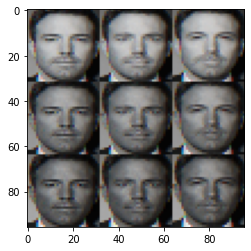

Ben


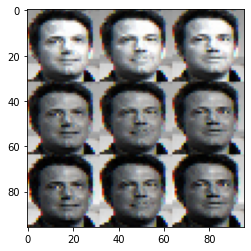

Ben


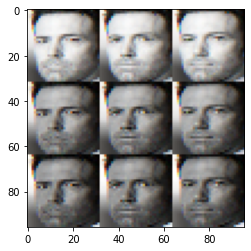

Ben


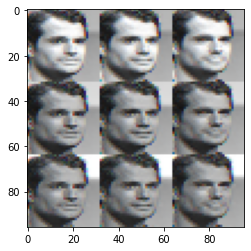

Henry


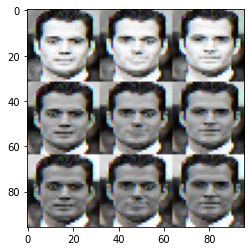

Henry


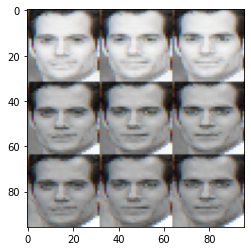

Henry


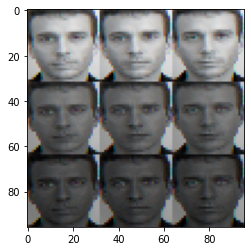

A


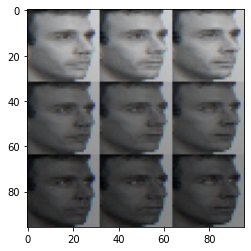

A


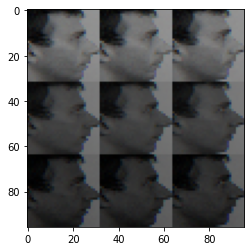

A


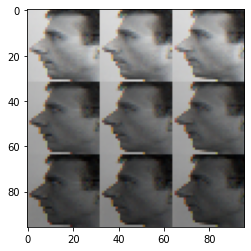

A


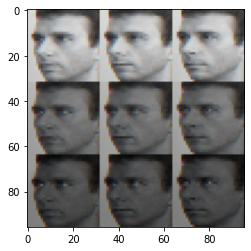

A


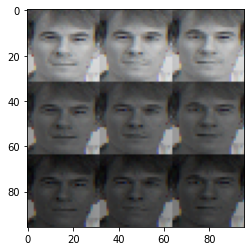

B


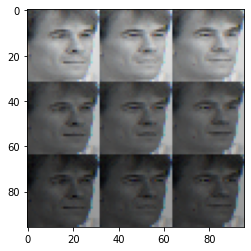

B


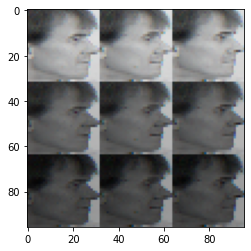

B


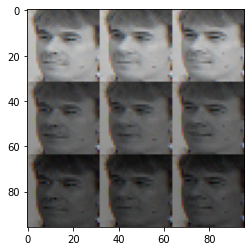

B


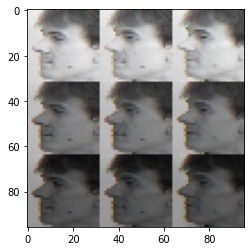

B


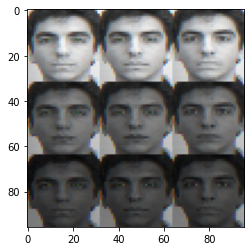

D


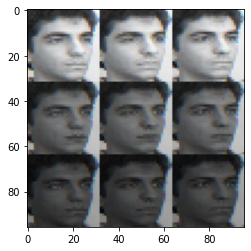

D


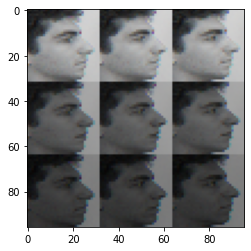

D


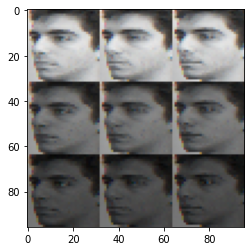

D


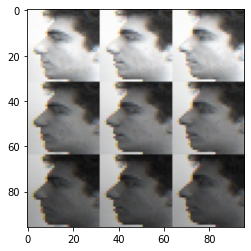

D


In [ ]:
all_encs=all_image_encodings(images,labels,model)

In [ ]:
def find_min_dist(image_enc,all_encs):          #Function to find minimum L2 distance
  l2 = PairwiseDistance(2)
  min = None
  min_name = None
  for i in all_encs:
    dist = l2.forward(image_enc,i)
    
    if min == None :
       min = dist
       min_name = all_encs[i] 
    else:
      if dist < min:
        min=dist
        min_name = all_encs[i]
  print(min)      
  return min_name     

In [ ]:
def recognise(path,all_encs,model):     #Face recognise function , returns name of the person
  image = cv2.imread(path)[...,::-1]
  image = np.around(np.transpose(image, (2,0,1))/255.0, decimals=12)
  plt.imshow(image.reshape(96,96,3))
  plt.show()

  image = torch.from_numpy(image).float().cuda()[None,...]
  image_enc = model(image)
  name = find_min_dist(image_enc,all_encs)
  return name


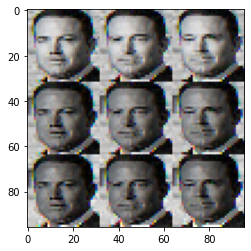

tensor([0.0162], device='cuda:0', grad_fn=<NormBackward1>)


'Ben'

In [ ]:
recognise('/content/ben_test.PNG',all_encs,model)